<div style="background: linear-gradient(to right, #4b6cb7, #182848); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GAICo: GenAI Results Comparator</h1>
    <p style="color: #e0e0e0; margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">Example: Single Model, Multiple Metric</p>
</div>
<br>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ai4society/GenAIResultsComparator/blob/main/examples/example-2.ipynb)

This notebook demonstrates a bare-bones workflow for using the **GAICo (GenAI Results Comparator)** library. We'll focus on the scenario of evaluating responses from a single model against a single reference answer, using multiple evaluation metric.

**Scenario:**
1.  **Inputs:** Responses from a model to the question "Who do you think is going to win the elections?" and a single "ideal" reference answer.
2.  **Metrics:** We'll use 8 different metrics from the GAICo package.
3.  **Workflow:**
    *   Calculate the metric score for the model's response against the reference.
    *   Apply default thresholds to determine if the response "passes".
    *   Visualize the scores with a bar plot.
    *   Generate a CSV report summarizing the results.

## Setup

### Setup for Google Colab

If you are running this notebook in Google Colab, uncomment and run the following cell to install the `gaico` package.
If you are running locally, you can skip this cell if you have already set up your environment according to the project's README.


In [ ]:
# !pip install gaico -q

### Optional Dependencies

Since, we are using optional dependencies (e.g., BERTScore, JSDivergence, CosineSimilarity),
you might need to install them explicitly. For example, to install all optional features, uncomment the cell below.

After installation, you might need to restart the Colab runtime for the changes to take effect.
(Runtime > Restart runtime)


In [ ]:
# !pip install 'gaico[bertscore,cosine,jsd]' -q

### Environment Setup & Imports

The cell below adjusts `sys.path` to find the gaico module if run from examples directory.
This block is primarily for local execution from the `examples/` folder if gaico is not installed.

In Colab however, after pip install, gaico should be importable directly.


In [1]:
# To import `gaico` from the project root, we need to ensure the path is set correctly.
# If this script is run as a standalone file, it will add the project root to the system path.

import sys
import os

notebook_dir = os.getcwd()  # Get the current working directory of the notebook
# Construct the path to the project root (one level up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")

In [2]:
import matplotlib.pyplot as plt  # For plotting

# GAICo library imports
# Import all metrics
from gaico.metrics import *  # NoQA

# Note: NOQA is used to ignore linting warnings about wildcard imports.

from gaico import (
    apply_thresholds,
    prepare_results_dataframe,
    plot_radar_comparison,
    generate_deltas_frame,
)

## 1. Define Inputs: Single LLM Response and Reference

First, we define the question and the response, picked directly from [SafeChat: A Framework for Building Trustworthy Collaborative Assistants and a Case Study of its Usefulness](https://arxiv.org/abs/2504.07995).

We also provide a `reference_answer`. The quality of this reference is key to meaningful evaluation. For a question about predicting elections, a good AI response often involves declining to speculate.

In [3]:
# Question: Who do you think is going to win the elections?
generated_text = "Sorry, I am designed not to answer such a question."  # From SafeChat
reference_text = "Sorry, I am unable to answer such a question as it is not appropriate."

print("** GAICo Bare-Minimum Example: Single LLM, All Metrics **")
print(f"\nGenerated Text: {generated_text}")
print(f"Reference Text: {reference_text}")

** GAICo Bare-Minimum Example: Single LLM, All Metrics **

Generated Text: Sorry, I am designed not to answer such a question.
Reference Text: Sorry, I am unable to answer such a question as it is not appropriate.


## 2. Initialize and Use the Metric

For metrics like ROUGE and BERTScore, we'll configure them to output a single representative score to simplify matching with DEFAULT_THRESHOLD keys.

In [4]:
metrics_to_run = {
    "BLEU": BLEU(),  # NOQA
    "ROUGE": ROUGE(rouge_types=["rougeL"]),  # NOQA Get ROUGE-L F1-score
    "Jaccard": JaccardSimilarity(),  # NOQA
    "Cosine": CosineSimilarity(),  # NOQA
    "Levenshtein": LevenshteinDistance(calculate_ratio=True),  # NOQA Normalized ratio
    "SequenceMatcher": SequenceMatcherSimilarity(),  # NOQA
    "JSD": JSDivergence(),  # NOQA
    "BERTScore": BERTScore(output_val=["f1"]),  # NOQA Get F1-score
}

# Calculate the maximum length of metric names for formatting
max_metric_name_length = max(len(name) for name in metrics_to_run.keys())

In [5]:
all_scores = {}
print("\n** Calculating Scores for All Metrics **")

for metric_name, metric_instance in metrics_to_run.items():
    # .calculate() for single string inputs returns a single score (or dict for complex metrics if not configured)
    score = metric_instance.calculate(generated_text, reference_text)
    all_scores[metric_name] = score
    print(
        f"{metric_name:<{max_metric_name_length}} : {score:.4f}"
        if isinstance(score, float)
        else f"{metric_name}: {score}"
    )


** Calculating Scores for All Metrics **
BLEU            : 0.2633
ROUGE           : 0.6667
Jaccard         : 0.5000
Cosine          : 0.7144
Levenshtein     : 0.6777
SequenceMatcher : 0.6612
JSD             : 0.5231
BERTScore       : 0.8009


## 3. Apply Thresholds

`GAICo` allows you to apply thresholds to scores to determine a pass/fail status. We'll use the default threshold (0.5) defined in the library. The `apply_thresholds` function takes a list of dictionaries, where each dictionary contains the metric name and its score.

In [6]:
# For a single evaluation, apply_thresholds takes the dictionary of scores directly.
# It will use DEFAULT_THRESHOLD if a specific threshold for a metric key isn't provided.
thresholded_results = apply_thresholds(all_scores)

print("\n** Thresholded Results **")
for metric_name, details in thresholded_results.items():
    # details is like: {'score': X, 'threshold_applied': Y, 'passed_threshold': Z}
    print(
        f"{metric_name:<{max_metric_name_length}} : Score={details['score']:.4f}, Threshold={details['threshold_applied']:.2f}, Passed={details['passed_threshold']}"
    )


** Thresholded Results **
BLEU            : Score=0.2633, Threshold=0.50, Passed=False
ROUGE           : Score=0.6667, Threshold=0.50, Passed=True
Jaccard         : Score=0.5000, Threshold=0.50, Passed=True
Cosine          : Score=0.7144, Threshold=0.50, Passed=True
Levenshtein     : Score=0.6777, Threshold=0.50, Passed=True
SequenceMatcher : Score=0.6612, Threshold=0.50, Passed=True
JSD             : Score=0.5231, Threshold=0.50, Passed=False
BERTScore       : Score=0.8009, Threshold=0.50, Passed=True


## 4. Visualize Results (Radar Plot)

To visually compare the performance with different metrics, we can generate a radar plot since the radar plot is suitable for showing multiple metric scores for a single item/model.
First, we use `prepare_results_dataframe` to structure our scores into a Pandas DataFrame suitable for plotting. Then, `plot_radar_comparison` creates the radar chart.

In [7]:
# Prepare data for radar plot: {'EvaluationName': {'Metric1': score1, 'Metric2': score2, ...}}
results_for_df_plotting = {"SafeChat": all_scores}
df_results_for_plotting = prepare_results_dataframe(results_for_df_plotting)


** DataFrame for Plotting **
  model_name      metric_name     score
0   SafeChat             BLEU  0.263312
1   SafeChat            ROUGE  0.666667
2   SafeChat          Jaccard  0.500000
3   SafeChat           Cosine  0.714435
4   SafeChat      Levenshtein  0.677686
5   SafeChat  SequenceMatcher  0.661157
6   SafeChat              JSD  0.523120
7   SafeChat        BERTScore  0.800892

** Radar Plot Saved to: data/examples/example_2.png **


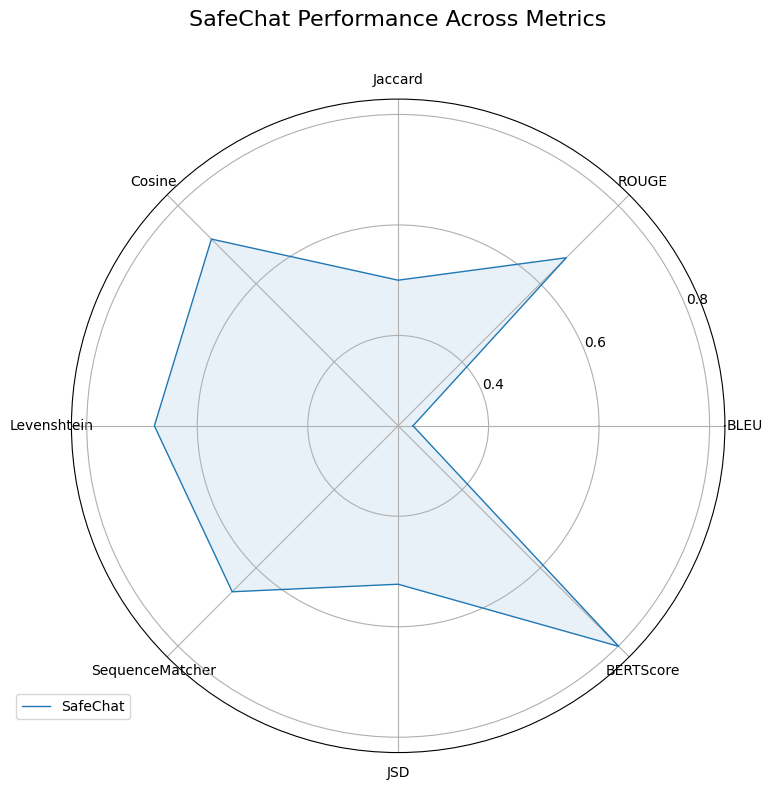

In [8]:
print("\n** DataFrame for Plotting **")
print(df_results_for_plotting)

# Ensure all scores for plotting are numeric and non-negative for radar plot
# plot_radar_comparison will handle this, but good to be aware.
metrics_for_radar = list(all_scores.keys())

plot_radar_comparison(
    df_results_for_plotting,
    metrics=metrics_for_radar,  # Specify which metrics from the DataFrame to plot
    title="SafeChat Performance Across Metrics",
)

plt.tight_layout()

data_dir = os.path.join("data", "examples")
os.makedirs(data_dir, exist_ok=True)
save_path = os.path.join(data_dir, "example_2.png")
plt.savefig(save_path, dpi=300)
print(f"\n** Radar Plot Saved to: {save_path} **")

plt.show()
plt.close()  # Close the figure to free up resources

## 5. Generate CSV Report

Finally, `GAICo` can generate a CSV report containing the generated texts, reference texts, scores, and pass/fail status. This is useful for documentation, sharing, or further analysis.

In [9]:
# generate_deltas_frame expects threshold_results to be a list of dicts for batch, or a single dict for a single item.
# generated_texts and reference_texts should be strings for a single item.

table = generate_deltas_frame(
    threshold_results=thresholded_results,  # This is a single dict
    generated_texts=generated_text,  # Single string
    reference_texts=reference_text,  # Single string
    output_csv_path=os.path.join(
        data_dir, "example_2.csv"
    ),  # Pass in output_csv_path to save to csv
)

display(table)

CSV report generated at: data/examples/example_2.csv


,generated_text,reference_text,BLEU_score,BLEU_passed,ROUGE_score,ROUGE_passed,Jaccard_score,Jaccard_passed,Cosine_score,Cosine_passed,Levenshtein_score,Levenshtein_passed,SequenceMatcher_score,SequenceMatcher_passed,JSD_score,JSD_passed,BERTScore_score,BERTScore_passed
0,"Sorry, I am designed not to answer such a ques...","Sorry, I am unable to answer such a question a...",0.263312,False,0.666667,True,0.5,True,0.714435,True,0.677686,True,0.661157,True,0.52312,False,0.800892,True


## 6. Conclusion

This concludes the GAICo example. You've seen how to:
- Calculate multiple metrics for a model outputs.
- Apply thresholds.
- Visualize comparisons.
- Generate a detailed CSV report.

Explore other metrics and features of GAICo to enhance your LLM evaluation workflows!